# Introductie tot Deep Learning met Keras en TensorFlow
## Les 10. Convolutionele neurale netwerken

**Thijs van den Berg, Tijmen Muller en Joost Vanstreels (2021)**

In de eerste twee lessen waarin we dit notebook gebruikt hebben, zijn we aan de slag gegaan met neurale netwerken. In deze les gebruiken we het notebook een laatste keer om aan de slag te gaan met convolutionele neurale netwerken (CNN's of ConvNets), één van de vormen van deep learning. 

We zullen zien dat neurale netwerken een aantal beperkingen hebben en hoe we die beperkingen kunnen oplossen met ConvNets. Tijdens deze workshop gaan we de basisstappen doorlopen om een simpel ConvNet te maken met behulp van de populaire libraries van Google. We gaan de Keras library gebruiken, deze library gebruikt onder water de TensorFlow library.

## Doel notebook

Het doel van dit notebook is om een aantal voorbeelden te geven van de werking van convolutionele netwerken neurale netwerken:
- Wat zijn de beperkingen van neurale netwerken?
- Wat is de toegevoegde waarde van convolutionele netwerken?
- Hoe werken deze convolutionele netwerken?

## Opzet notebook

Dit notebook bevat geen opdrachten maar enkel theoretische uitleg en praktische codevoorbeelden over de volgende onderwerpen:
- Convolutie
- Filters
- Padding
- Pooling
- De architectuur van een ConvNet
- Data augmentation

Het notebook bestaat uit drie delen:
- I. De beperkingen van neurale netwerken
- II. Een eerste ConvNet voor MNIST
- III. ConvNet voor MNIST met augmented data

# Deel I. De beperkingen van neurale netwerken

We hebben in het eerste deel van de workshop zijn we aan de slag gegaan met de 'Hello World' van neurale netwerken: het herkennen van de handgeschreven cijfers van de MNIST dataset. De dataset is redelijk gestructureerd, plaatjes staan bijvoorbeeld altijd in het midden en zijn altijd ongeveer even groot:

<img src="https://i.imgur.com/86wacJG.png" >

## Beperkingen van neurale netwerken

De netwerken die we getraind hebben, behaalden scores van zo'n 98% accuracy. Da's zeker niet slecht! Maar wat zou er gebeuren wanneer de plaatjes er net even iets anders uit zien?

In onderstaand plaatje zie een '3' en een aantal varianten:

<img src="https://i.imgur.com/KfyF1v2.png" />

Het is telkens dezelfde 3 maar dan:
- Verplaatst;
- Verkleurd;
- Gedraaid;
- Verkleind;
- Negatief.

In alle gevallen zal ons neuraal netwerk de m`n`ist in gaan omdat deze drieën afwijken van de drieën in de trainset. Je zou dit soort afwijkende drieën kunnen toevoegen aan de trainset maar bij een nieuwe afwijking slaat je netwerk weer eerst de plank mis. 

Laten we dit eerst aantonen.

## Benodigde libraries 

We hebben een aantal libraries nodig, sommigen kennen jullie al.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import random  
import time

import tensorflow as tf

from tensorflow.keras.datasets import mnist     # MNIST dataset is onderdeel van Keras
from tensorflow.keras.models import Sequential  # Het type neuraal netwerk dat we gaan gebruiken

from tensorflow.keras.layers import Dense, Dropout, Activation  # Verschillende type lagen die we gaan gebruiken
from tensorflow.keras.optimizers import SGD, Adam, schedules
from tensorflow.keras import utils    


In [33]:
# CUDA-shizzle
# Geheugengebruik GPU beperken
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
session = tf.compat.v1.Session(config=config)

print(f"TensorFlow v{tf.version.VERSION}, {len(tf.config.list_physical_devices('GPU'))} GPUs:")
tf.config.list_physical_devices('GPU')

TensorFlow v2.15.0, 0 GPUs:


[]

## Stap 1. Data exploration 

De MNIST dataset is gebundeld in Keras, we kunnen deze eenvoudig downloaden.

In [34]:
# Inladen van de dataset, deze is al gesplitst in een train- en testset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (60000, 28, 28)
y_train shape (60000,)
x_test shape (10000, 28, 28)
y_test shape (10000,)


## Stap 2. Data preparation 

We gaan de dataset zodanig aanpassen dat de plaatjes wat minder gestructureerd zijn. We noemen dit *data augmentation*: het vergroten van de dataset met extra plaatjes. De nieuwe plaatjes zijn gebaseerd op de bestaande plaatjes. We gebruiken een aantal manieren om de plaatjes aan te passen.

In [35]:
X_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
X_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [36]:
## Met np_utils wordt de one-hot encoding gedaan
nb_classes = 10 # aantal classes

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

print(f"Y_train: {Y_train.shape}, Y_test: {Y_test.shape}")

Y_train: (60000, 10), Y_test: (10000, 10)


### Data augmentation
Hieronder wordt code getoond voor een aantal acties zoals het draaien, verplaatsen, rekken en zoomen van plaatjes. Dit soort aanpassingen wordt *data augmentation* genoemd.

Eerst moeten we een library importeren en gebruiken we een functie om de resultaten te visualiseren. We zullen eerst een aantal voorbeelden geven van de werking van deze library. De code is afkomstig van https://medium.com/the-data-science-publication/how-to-augment-the-mnist-dataset-using-tensorflow-4fbf113e99a0



In [37]:
# import relevant library
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [38]:
# Code om voor en na te visualiseren
def plot_numbers(x, X, y):

  # define number of rows & columns
  num_row = 2
  num_col = 8
  num= num_row*num_col
  # plot before
  print('BEFORE:\n')
  # plot images
  fig1, axes1 = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(num):
      ax = axes1[i//num_col, i%num_col]
      ax.imshow(x[i], cmap='gray_r')
      ax.set_title('Label: {}'.format(y[i]))
  #plt.tight_layout()
  plt.show()
  # plot after
  print('AFTER:\n')
  fig2, axes2 = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for X, Y in datagen.flow(X,y.reshape(y.shape[0], 1),batch_size=num,shuffle=False):
      for i in range(0, num):
            ax = axes2[i//num_col, i%num_col]
            ax.imshow(X[i].reshape(28,28), cmap='gray_r')
            ax.set_title('Label: {}'.format(int(Y[i])))
      break
  #plt.tight_layout()
  plt.show()

#### Draaien
Hieronder wordt code getoond voor het draaien van plaatjes. De input parameter is een waarde voor maximale draaihoek. De ImageDataGenerator library kiest willekeurig voor de richting waarin gedraaid wordt.

BEFORE:



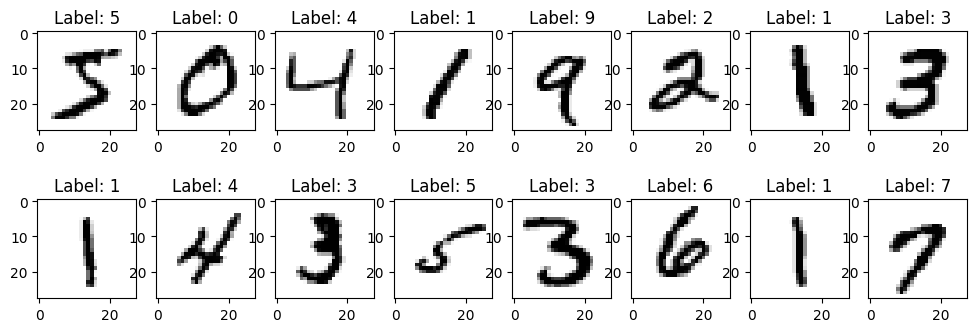

AFTER:



C:\Users\hvhee\AppData\Local\Temp\ipykernel_19040\1111505687.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('Label: {}'.format(int(Y[i])))


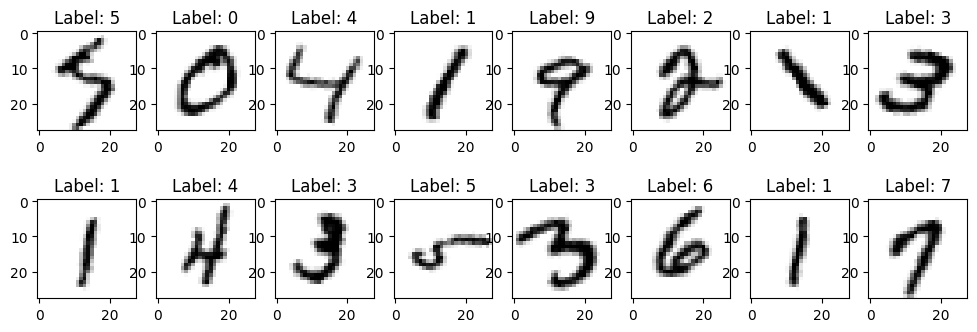

In [39]:
# specify the maximum rotation_range angle
rotation_range_val = 30

# create the class object
datagen = ImageDataGenerator(rotation_range=rotation_range_val)
# fit the generator
datagen.fit(X_train)

# Hieronder vind je de code voor het visualiseren van de veranderingen
plot_numbers(x_train, X_train, y_train)

#### Verplaatsen
Hieronder wordt code getoond voor het verplaatsen van plaatjes. De input parameters zijn een waarde voor de mate waarin horizontaal en verticaal verschoven mag worden. De ImageDataGenerator library kiest willekeurig voor de richtingen waarin verplaatst wordt.

BEFORE:



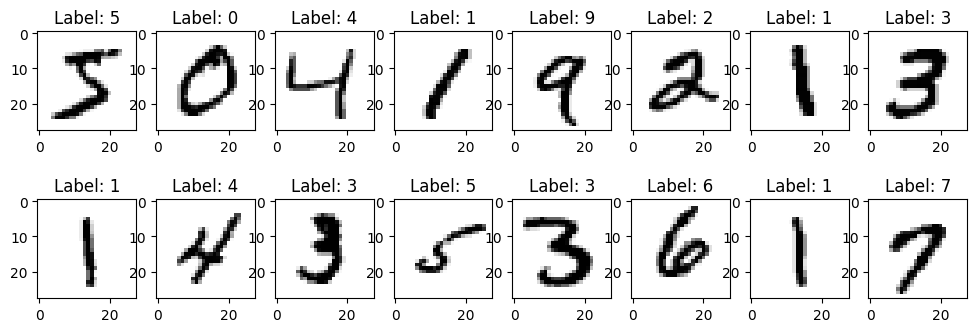

AFTER:



C:\Users\hvhee\AppData\Local\Temp\ipykernel_19040\1111505687.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('Label: {}'.format(int(Y[i])))


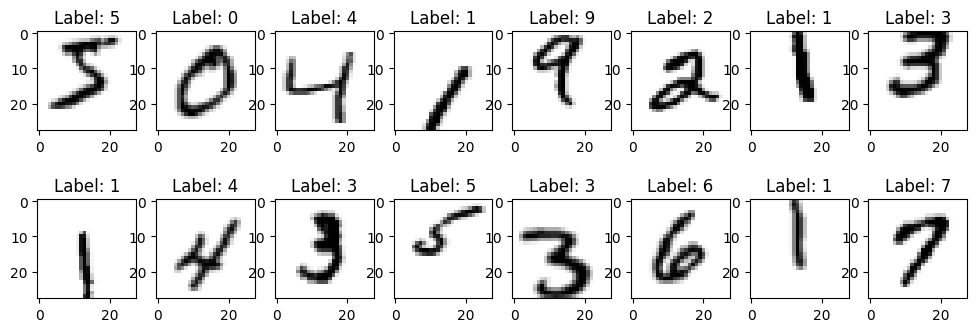

In [40]:
# specify the width and height shift arguments
width_shift_val = 0.25
height_shift_val = 1.25

# create the class object
datagen = ImageDataGenerator(width_shift_range=width_shift_val, height_shift_range=height_shift_val)

# fit the generator
datagen.fit(X_train)

# Hieronder vind je de code voor het visualiseren van de veranderingen
plot_numbers(x_train, X_train, y_train)

#### Rekken
Hieronder wordt code getoond voor het in- en uitrekken van plaatjes. De input parameter is een waarde voor de mate waarin gerekt kan worden. De ImageDataGenerator library kiest willekeurig voor een waarde voor zowel horizontaal als verticaal rekken.

BEFORE:



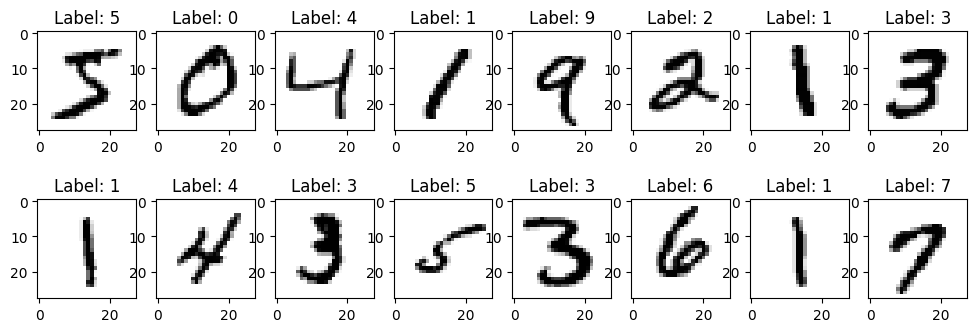

AFTER:



C:\Users\hvhee\AppData\Local\Temp\ipykernel_19040\1111505687.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('Label: {}'.format(int(Y[i])))


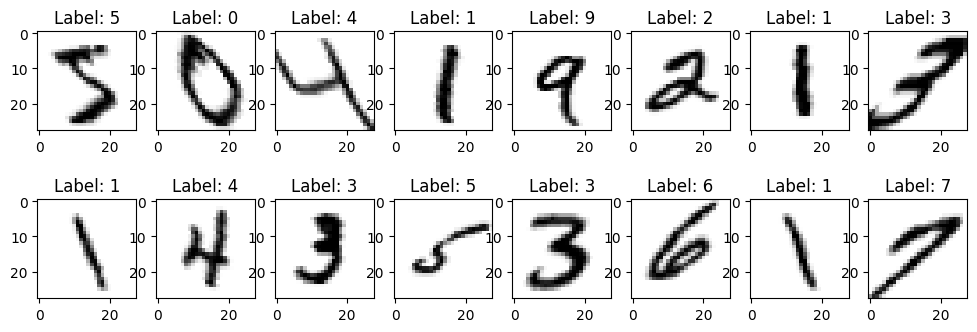

In [41]:
# specify the shear argument
shear_range_val=45

# create the class object
datagen = ImageDataGenerator(shear_range=shear_range_val)

# fit the generator
datagen.fit(X_train)

# Hieronder vind je de code voor het visualiseren van de veranderingen
plot_numbers(x_train, X_train, y_train)

#### Zoomen
Hieronder wordt code getoond voor het in- en uitzoomen van plaatjes. De input parameter is een bereik voor het in- en uitzoomen. De ImageDataGenerator library kiest willekeurig voor een waarde voor zowel horizontaal als verticaal inzoomen.

BEFORE:



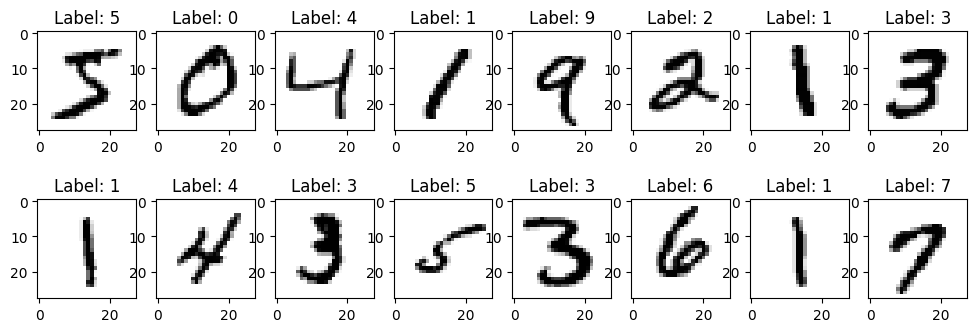

AFTER:



C:\Users\hvhee\AppData\Local\Temp\ipykernel_19040\1111505687.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('Label: {}'.format(int(Y[i])))


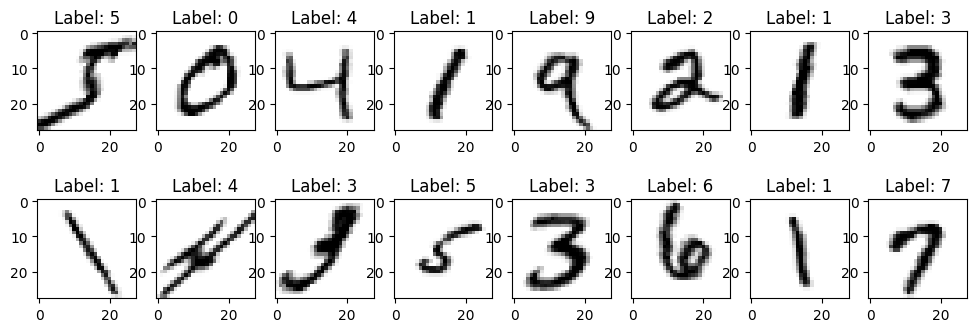

In [42]:
# specify the zoom argument
zoom_range_val=[0.5,1.5]

# create the class object
datagen = ImageDataGenerator(shear_range=shear_range_val)

# fit the generator
datagen.fit(X_train)

# Hieronder vind je de code voor het visualiseren van de veranderingen
plot_numbers(x_train, X_train, y_train)

### ImageDataGenerator object aanmaken

De library van Keras maakt het mogelijk om alle aanpassingen te combineren. Hiervoor maak je een ImageDataGenerator object aan waarin je alle aanpassingen specificeert. 

In [43]:
# Bron: https://keras.io/api/preprocessing/image/

# Bereik / maximale waardes van de aanpassingen specificeren
rotation_range_val = 15
width_shift_val = 0.15
height_shift_val = 0.15
shear_range_val = 25
zoom_range_val = [0.9,1.1]

# Combineren in een ImageDataGenerator object
datagen = ImageDataGenerator(rotation_range = rotation_range_val,
                             width_shift_range = width_shift_val,
                             height_shift_range = height_shift_val,
                             zoom_range=zoom_range_val)

En nu gaan we `X_test` aanpassen: we gaan het ImageDataGenerator object toepassen op deze testset. Dat betekent dat we de plaatjes in deze testset aan gaan laten passen. Voor elk plaatje zullen willekeurige aanpassingen uitgevoerd worden binnen het bereik dat het gespecificeerd is in het ImageDataGenerator object. 

Het resultaat slaan we op in `X_test_augmented`.

In [44]:
# Voordat de plaatjes aangepast kunnen worden, moeten er een aantal berekeningen uitgevoerd worden op het object
datagen.fit(X_test)

# De resultaten slaan we op in een nieuwe dataset
X_test_augmented, Y_test_augmented = next(datagen.flow(X_test, Y_test, batch_size=X_test.shape[0], shuffle=False))

Je ziet hieronder dat de plaatjes gedraaid, verplaatst, vergroot en gerekt worden.

BEFORE:



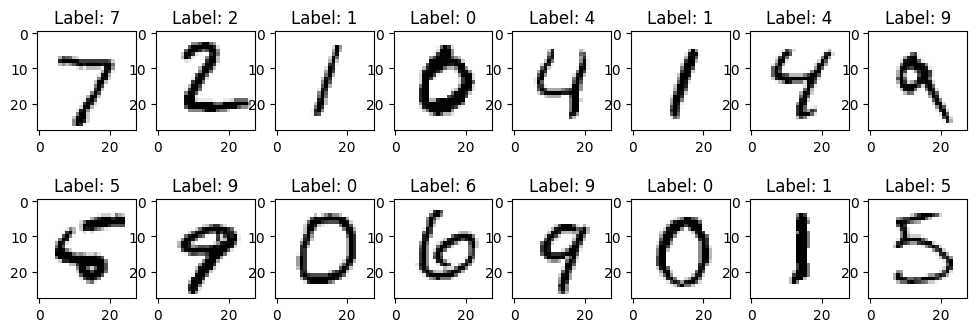

AFTER:



C:\Users\hvhee\AppData\Local\Temp\ipykernel_19040\1111505687.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('Label: {}'.format(int(Y[i])))


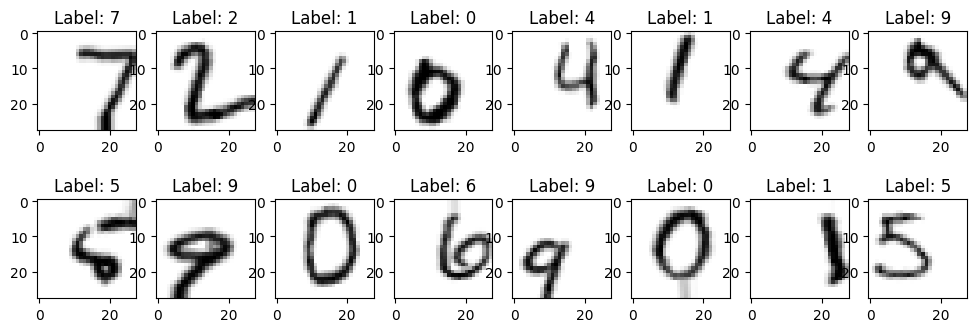

In [45]:
plot_numbers(x_test, X_test_augmented, y_test)

In [46]:
# Nu moeten we de nieuwe datasets nog reshapen voor het neuraal netwerk

X_train = x_train.reshape(60_000, 784)  # Reshape de 60.000 plaatjes van 28 x 28 matrices naar 60.000 784-lengte vectoren.
X_test = x_test.reshape(10_000, 784)
X_test_augmented = X_test_augmented.reshape(10_000, 784)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')
X_test_augmented = X_test_augmented.astype('float32')

X_train /= 255  
X_test /= 255
X_test_augmented /= 255         

## 3. Modelling

We gaan eerst een neuraal netwerk opbouwen. Hier gebruiken we het *oude* neuraal netwerk van les 9 voor.

In [47]:
model_old = Sequential()
model_old.add(Dense(512, input_shape=(784,))) #(784,)
model_old.add(Activation('sigmoid'))
model_old.add(Dropout(0.4))

model_old.add(Dense(512))
model_old.add(Activation('sigmoid'))

model_old.add(Dense(10))
model_old.add(Activation('softmax'))

lr_schedule = schedules.ExponentialDecay(initial_learning_rate=0.01,
                                         decay_steps=2_000,
                                         decay_rate=0.9)

opt_adam = Adam(learning_rate=lr_schedule)
model_old.compile(loss="categorical_crossentropy", optimizer=opt_adam, metrics=["accuracy"])

model_old.fit(X_train, Y_train,
               batch_size=128,
               epochs=5,
               verbose=1)

Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.3836 - accuracy: 0.8858
Epoch 2/5
469/469 [==============================] - 4s 9ms/step - loss: 0.1498 - accuracy: 0.9539
Epoch 3/5
469/469 [==============================] - 4s 9ms/step - loss: 0.1198 - accuracy: 0.9633
Epoch 4/5
469/469 [==============================] - 4s 9ms/step - loss: 0.1040 - accuracy: 0.9670
Epoch 5/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0899 - accuracy: 0.9713


## Stap 4. Evalueren

Laten we eerst nog even kijken hoe goed de score is voor de originele testdata en daarna naar de augmented testdata.

In [48]:
# Score X_test
score = model_old.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0806 - accuracy: 0.9759
Test score: 0.08059781044721603
Test accuracy: 0.9758999943733215


In [49]:
# score X_test_augmented
score = model_old.evaluate(X_test_augmented, Y_test_augmented)
print('Test score:', score[0])
print('Test accuracy:', score[1])

  1/313 [..............................] - ETA: 9s - loss: 2.3747 - accuracy: 0.4688

313/313 [==============================] - 1s 3ms/step - loss: 2.7734 - accuracy: 0.5055
Test score: 2.773388385772705
Test accuracy: 0.5055000185966492


## Conclusie

De vorige keer hebben we gezien dat het neuraal netwerk tot ruim 97% accuracy kon komen, maar met deze augmented testset valt het tegen... Als de plaatjes in de praktijk een klein beetje afwijken, daalt de score tot onder de 50%.

We gaan nu kijken hoe dat met ConvNets werkt.

# Deel II. Deep learning met convolutionele neurale netwerken

## Kijken zoals mensen kijken
Wanneer wij een plaatje zien, gaan wij niet naar alle pixels kijken en daarmee bepalen of een plaatje een 3 is of iets anders. Wij kijken naar bepaalde vormen of structuren, bijvoorbeeld de drie pootjes die een drie heeft of de twee rondjes die een acht vormen. We kijken naar scheidingen tussen objecten op een foto of zaken die op de voorgrond of achtergrond staan. Op die manier maken wij onze voorspellingen. En dat is precies wat convolutionele neurale netwerken doen.

## Patronen, patronen van patronen en patronen van patronen van patronen
Dit is waarschijnlijk de meest onduidelijke koptekst ooit... maar hopelijk verklaart dit plaatje de kop: 

<img src="https://i.imgur.com/wdqFecH.png" />

Je ziet in de onderste laag de patronen die gevonden worden in een plaatje. De tweede laag laat zien dat door combinaties van patronen te maken, je nieuwe patronen vindt (= patronen van patronen). Daarboven zie je dat die patronen van patronen gecombineerd zijn tot patronen van patronen van patronen!

Die bovenste patronen van patronen van patronen komen in de buurt van de objecten die we zoeken. En dat is precies wat we willen bereiken met ConvNets!

Het idee is dat we niet alle pixels van een plaatje afzonderlijk gaan bekijken maar dat we naar patronen gaan zoeken om op die manier objecten te herkennen. Hoe dat werkt in een ConvNet leggen we hieronder uit.

## De bouwstenen van een ConvNet
We gaan kijken naar de belangrijkste bouwstenen van een Convnet:
1. Convolutionele lagen
2. ReLU's
3. Pooling
4. Fully connected layer

### 1. Convolutionele lagen

Convolutionele neurale netwerken voegen nog meer lagen toe aan een netwerk, daar komt de naam *deep learning* vandaan: het netwerk wordt steeds dieper. Maar de convolutionele lagen werken wel iets anders: het zijn lagen die iets speciaal doen zoals randen detecteren of bepaalde clusters van pixels (bijvoorbeeld een *pootje* of een *rondje*). Hier komt unsupervised learning weer om de hoek kijken want de computer gaat zelf bepalen welke clusters vaker terug komen en daarmee interessant zijn.

#### Extra features vinden 

Het doel van convolutie is om extra features te vinden in een plaatje. Tot nu toe beschouwden we alle pixels van een plaatje als de features. Maar met convolutie gaan we op zoek naar nieuwe kenmerken van een plaatje, zoals zo'n *pootje* of *rondje*. 

#### Local perceptive field

Een convolutional layer maakt gebruik van filters. Zo’n filter bekijkt een klein deel van een plaatje, bijvoorbeeld 5 x 5 pixels. Dat filter schuif je over het hele plaatje heen, van links naar rechts en van boven naar beneden. Het idee is dat je met zo’n filter op zoek gaat naar bepaalde patronen van een plaatje. Nielsen gebruikt de term local perceptive field om aan te geven dat je niet het hele plaatje beschouwd, maar kleine delen van het plaatje.

<img src = 'https://i.imgur.com/gEm0DqN.gif' >

In bovenstaande animatie zie je dat er in dit plaatje van 5 x 5 pixels gekeken wordt naar alle 3 x 3 vlakken in dat plaatje. Met behulp van wiskundige berekeningen wordt er *iets* gezegd over elk vlak. We noemen dat 3 x 3 vlak een *kernel*. De resultaten van deze berekeningen kun je weer opslaan, in dit geval levert dat 9 nieuwe features op naast de originele 25 features (= de 5 x 5 pixels).

### Convolutie op convolutie

Het mooie van convolutionele lagen, is dat je ze op elkaar kunt stapelen en daarmee de verschillende filters kunt combineren. 

### 2. Rectified Linear Unit (ReLU)

De ReLU is een activatiefunctie net zoals de sigmoid en tanh. ReLU’s zijn erg populair omdat de simpele afgeleide zorgt voor een snellere convergentie bij gradient descent. Daarnaast is het makkelijker om de afgeleide van de ReLU te berekenen en daarom is de ReLU computationeel goedkoper. 

Een ReLU vervangt in de basis alle negatieve waardes met een 0. Je kunt dit ook zien als een manier om een plaatje te verkleinen: alle output kleiner dan 0 is niet relevant en vervang je met 0. 
<img src = 'https://miro.medium.com/max/357/1*oePAhrm74RNnNEolprmTaQ.png' >

Elke convolutionele laag wordt opgevolgd door een ReLU laag.

### 3. Pooling

Het idee van een pooling layer is om een plaatje te verkleinen. Met behulp van een MAX pooling filter je de laagste waardes die je gekregen hebt na een convolutional layer om alleen de hoogste waarde over te houden. Je gaat er vanuit dat de hoogste waardes het belangrijkste zijn en dat de andere waardes eigenlijk niet relevant zijn.

<img src = 'https://i.imgur.com/AGMVPbL.png' >

Na een of meerdere convolutionele en ReLU lagen, voeg je een pool laag toe. 

De term *deep* uit 'Deep learning' komt van het feit dat je dit vaker kunt doen (dus meerdere conv layers met een pool en dat dan vaker herhalen) waardoor er een heel diep netwerk ontstaat.

### 4. Fully connected layer
Wat je in de hierboven genoemde lagen eigenlijk doet is patronen van objecten in plaatjes detecteren. En patronen van patronen. En patronen van patronen van patronen. Enzovoorts. Het resultaat van al die lagen is een overzicht van gevonden patronen. En die patronen zijn de input voor het neuraal netwerk dat op basis van deze informatie gaat classificeren. 

Het laatste deel van een ConvNet is een *fully connected layer* ofwel een *fully connected neural network*. Deze krijgt dus niet het plaatje als input, maar de gevonden patronen. 

**Merk op**: de output van de allerlaatste laag is weer in de vorm van een of meerdere matrices. Je moet (net als bij een *gewoon* neuraal netwerk) de input vertalen naar een vector.




## Stap 1. Data exploration

We gaan een eerste ConvNet bouwen voor de *originele* MNIST data, dus zonder de data aan te passen.

In [50]:
# Aantal extra libraries importeren

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization

In [51]:
# MNIST opnieuw importeren
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## Stap 2. Data preparation

Voor het neurale netwerk hebben we de plaatjes omgevormd van een 28 x 28 matrix naar een vector met lengte 784. Dat gaan we straks ook doen, maar eerst willen we de plaatjes intact houden omdat we de filters over de plaatjes heen willen laten gaan. 

In [52]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         
X_test = X_test.astype('float32')

X_train /= 255                              
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [53]:
# One-hot formatten

nb_classes = 10 # number of unique digits

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

print(f"Y_train: {Y_train.shape}, Y_test: {Y_test.shape}")

Y_train: (60000, 10), Y_test: (10000, 10)


## Stap 3. Modelling
Hieronder geven we een voorbeeld van een ConvNet voor de standaard MNIST dataset, dus zonder data augmentation.

### Model opbouwen

Het model bestaat uit een aantal lagen. 

**1. Conv layer**

De eerste laag bestaat uit 32 3x3 filters met een ReLU. De input moet bij de eerste laag expliciet worden gegeven, de dimensies van de input zijn 28x28 pixels en er is maar één kleurwaarde dus vandaar dat de input 28x28x1 is.

De default waardes van stride (dat is 1) en padding (geen padding) worden gebruikt. Dat betekent dat de output (de zogenaamde *activation maps*) een dimensie van 26x26 hebben. Omdat er 32 filters zijn, is de totale dimensie 26x26x32. 

**Merk op:** de conv layers maken gebruik van *batch normalization*, hiermee normaliseer je de gewichten van een laag. Dit is een veelgebruikte manier om sneller en beter te kunnen fitten.

**2. Conv layer**

De tweede laag bestaat ook weer uit 32 filters van 3x3. Hierna volgt (uiteraard) ook weer een ReLU maar nu ook een max pool van 2x2.

De activation maps zijn nu 24x24x32 en na de max pool nog maar 12x12x32.

**3. en 4. Conv layers**

De derde en vierde laag gebruiken 64 filters waardoor we tot 8x8x64 activation maps komen die in de laatste laag door de max pool tot 4x4x64 verkleind wordt.

Laag 4 bevat ook nog de `Flatten` functie om voor de fully connected layer een vector te maken van deze drie-dimensionale matrix.

**5. en 6. Fully connected layer**

Het neuraal netwerk krijgt als input 1.024 inputs vanuit laag 4. Dat hoef je allemaal niet zelf te specificeren, dat regelt Keras voor je. Je moet natuurlijk wel aangeven uit hoeveel lagen de hidden layer bestaat en de output layer.

In [54]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28,28,1))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model.add(convLayer01)

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Convolution Layer 3
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6                       
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))                     # softmax activation

Hieronder zie je het resultaat. Kijk voor even naar de tweede kolom waar de dimensies van de output van elke laag getoond worden. 

In [55]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_5 (Bat  (None, 26, 26, 32)        128       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 26, 26, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_6 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 24, 24, 32)       

### Compilen
Ook hier moeten we het model gaan compilen met een loss function en optimizer.

In [56]:
# We gebruiken dezelfde loss function en optimizer als bij het neuraal netwerk

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fitten

Hierna kunnen we het model gaan fitten. De fit functie kent een aantal belangrijke parameters:
- batch_size: de grootte van de mini-batch
- steps_per_epoch: in principe is dit de grootte van X_train / batch_size en hoef je dat niet te specificeren, maar je kunt ervoor kiezen om slechts een deel van de dataset te gebruiken voor een epoch
- validation_split: dit is een hele belangrijke! In de praktijk zul je vaak werken met een train-, test- én devset. De devset gebruik je als een soort tussentijdse testset om tijdens het trainen in de gaten te houden wat de resultaten zijn voor deze testset. Je kunt hiermee in de gaten houden of de scores voor de devset blijven verbeteren en niet minder worden: dat is een indicatie van overfitten. De testset blijft onafhankelijk en gebruik je na afloop van het trainen. Met deze parameter kun je X_train splitsen in een trainset en devset (ter grootte van 0.2 van de originele X_train).

In [57]:
model.fit(X_train, Y_train, batch_size = 128, epochs=5, verbose=1, validation_split = 0.2, validation_steps=12000//128)

Epoch 1/5


375/375 [==============================] - 35s 88ms/step - loss: 0.0941 - accuracy: 0.9708 - val_loss: 1.0052 - val_accuracy: 0.6026
Epoch 2/5
375/375 [==============================] - 33s 89ms/step - loss: 0.0304 - accuracy: 0.9909 - val_loss: 0.0460 - val_accuracy: 0.9850
Epoch 3/5
375/375 [==============================] - 36s 96ms/step - loss: 0.0216 - accuracy: 0.9932 - val_loss: 0.0660 - val_accuracy: 0.9793
Epoch 4/5
375/375 [==============================] - 39s 105ms/step - loss: 0.0174 - accuracy: 0.9940 - val_loss: 0.0502 - val_accuracy: 0.9845
Epoch 5/5
375/375 [==============================] - 39s 105ms/step - loss: 0.0127 - accuracy: 0.9959 - val_loss: 0.0353 - val_accuracy: 0.9895


## Stap 4. Evalueren

Ook hier kunnen we kijken hoe goed de resultaten zijn.

In [58]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 3s 10ms/step - loss: 0.0300 - accuracy: 0.9909
Test loss: 0.0300
Test accuracy: 0.9909


Met een *normaal* neuraal netwerk kwamen we tot ongeveer 97.5% accuracy, met dit ConvNet komen we al tot 99%! Op naar de 100%!

Maar we willen natuurlijk ook even kijken hoe goed dit ConvNet het doet op de augmented testset.

In [59]:
# Bron: https://keras.io/api/preprocessing/image/

# Bereik / maximale waardes van de aanpassingen specificeren
rotation_range_val = 15
width_shift_val = 0.15
height_shift_val = 0.15
shear_range_val = 25
zoom_range_val = [0.9,1.1]

# Combineren in een ImageDataGenerator object
datagen = ImageDataGenerator(rotation_range = rotation_range_val,
                             width_shift_range = width_shift_val,
                             height_shift_range = height_shift_val,
                             zoom_range=zoom_range_val)

In [60]:
# Nu gaan we de datasets aanpassen

# Voordat de plaatjes aangepast kunnen worden, moeten er een aantal berekeningen uitgevoerd worden op het object
datagen.fit(X_test)

# De resultaten slaan we op in een nieuwe dataset
X_test_augmented, Y_test_augmented = next(datagen.flow(X_test, Y_test, batch_size=10_000))

In [61]:
loss, accuracy = model.evaluate(X_test_augmented, Y_test_augmented)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 3s 9ms/step - loss: 1.1113 - accuracy: 0.7632
Test loss: 1.1113
Test accuracy: 0.7632


Je ziet dat de accuracy hier ongeveer 75% is. Het ConvNet is nog niet zo robuust als we zouden hopen, maar ~75% is nog steeds een aardige score, zeker in vergelijking met de 50% van het neuraal netwerk.

# Deel III. Trainen met augmented data

Augmented data wordt in de praktijk om meerdere redenen gebruikt. 

- Dataset vergroten. Je kunt hiermee makkelijk je dataset uitbreiden. De aangepaste plaatjes zijn eigenlijk nieuwe plaatjes. Je kunt zo dus makkelijk je dataset vergroten.
- Overfitten voorkomen. Door aangepaste varianten van plaatjes aan te bieden aan je netwerk, verklein je de kans dat het netwerk zich aanpast aan de traindata.
- Robuustheid vergroten. Door het netwerk te trainen op allerlei varianten, zal het netwerk daar in de praktijk ook rekening mee houden. 

Dat klinkt misschien allemaal wat vaag, maar dat gaan we nu aantonen.

## Opzet experiment

We gaan eerst een ConvNet trainen op augmented data om daarna te kijken of de scores voor testdata veranderd zijn.

## Stap 2. Data preparation
De data hoeven we niet meer te bekijken, we gaan meteen door naar stap 2.: alle data weer prepareren.

In [62]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

In [63]:
nb_classes = 10 # number of unique digits

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

In [64]:
# Bereik / maximale waardes van de aanpassingen specificeren
rotation_range_val = 15
width_shift_val = 0.15
height_shift_val = 0.15
shear_range_val = 25
zoom_range_val = [0.9,1.1]

# Combineren in een ImageDataGenerator object
datagen = ImageDataGenerator(rotation_range = rotation_range_val,
                             width_shift_range = width_shift_val,
                             height_shift_range = height_shift_val,
                             zoom_range=zoom_range_val)

**Nieuw!** X_train gaan we niet op een nieuwe manier augmenten. 
Dit train_generator object maakt gebruik van de flow functie van de ImageDataGenerator. Deze flow functie haalt 128 random plaatjes uit X_train en voert daar random aanpassingen op uit. Deze train_generator geven was als input aan de fit functie van het ConvNet. Dit zorgt ervoor dat elke mini-batch uniek is. Dit zorgt voor een onbeperkte hoeveelheid data en verkleint de kans op overfitten.

In [65]:
datagen.fit(X_train)
train_generator = datagen.flow(X_train, Y_train, batch_size=128)

In [66]:
# X_test augmenten we wel op de oude manier
datagen.fit(X_test)

# De resultaten slaan we op in een nieuwe dataset
X_test_augmented, Y_test_augmented = next(datagen.flow(X_test, Y_test, batch_size=10_000))

In [67]:
X_train = X_train.astype('float32')         
X_test = X_test.astype('float32')
X_test_augmented.astype('float32')

X_train /= 255                              
X_test /= 255
X_test_augmented /= 255

## Stap 3. Modelling

We gaan het ConvNet trainen op de augmented data. 

In [68]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28,28,1))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model.add(convLayer01)

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Convolution Layer 3
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6                       
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))                     # softmax activation

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [69]:
train_generator = datagen.flow(X_train, Y_train, batch_size=128)

In [70]:
model.fit(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1)

Epoch 1/5
468/468 [==============================] - 56s 115ms/step - loss: 0.2235 - accuracy: 0.9305
Epoch 2/5
468/468 [==============================] - 52s 110ms/step - loss: 0.0797 - accuracy: 0.9749
Epoch 3/5
 62/468 [==>...........................] - ETA: 44s - loss: 0.0659 - accuracy: 0.9800

## Stap 4. Evalueren

Ook hier kunnen we kijken hoe goed de resultaten zijn. De vorige keer zagen we goeie scores voor de testset maar niet voor de augmented testset.

In [ ]:
loss, accuracy = model.evaluate(X_test_augmented, Y_test_augmented)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

### Conclusies

We zien nu dat de score voor de augmented testset ook harstikke goed is. Ook voor de normale testset is de score heel goed, zelfs hoger dan bij het trainen op de normale traindata! Het model is dus een stuk robuuster én beter geworden. 